In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Load stock data from Yahoo Finance
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close']]
    data = data.reset_index()
    return data

# Data Preprocessing
def prepare_data(data, window_size=60, future_days=120):  # Predict for 50 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])

    X, y = [], []
    for i in range(window_size, len(scaled_data) - future_days):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i + future_days, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler, scaled_data

# Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [3]:
# Define stock ticker and date range
ticker = "HINDCOPPER.NS"  # Example ticker for Hindustan Copper on NSE
start_date = "2020-01-01"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

# Load stock data
data = load_stock_data(ticker, start_date, end_date)

# Prepare data for training
future_days = 120  # Predict for 50 days
X, y, scaler, scaled_data = prepare_data(data, future_days=future_days)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Build and train LSTM model
model = build_lstm_model((X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0932 - val_loss: 0.0230
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0340 - val_loss: 0.0239
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0316 - val_loss: 0.0239
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0322 - val_loss: 0.0240
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0323 - val_loss: 0.0223
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0319 - val_loss: 0.0225
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0310 - val_loss: 0.0226
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0332 - val_loss: 0.0226
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0324 - val_loss: 0.0227
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0282 - val_loss: 0.0238
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0304 - val_loss: 0.0233
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0

In [5]:
# Predict future prices sequentially
def predict_future_prices(model, data, scaler, scaled_data, window_size=60, future_days=120):
    last_window = scaled_data[-window_size:]  # Use last actual scaled values

    X_pred = np.array([last_window])
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

    future_predictions = []
    for _ in range(future_days):
        pred = model.predict(X_pred)[0, 0]
        future_predictions.append(pred)

        # Shift the window and append the new prediction
        last_window = np.append(last_window[1:], pred).reshape(-1, 1)
        X_pred = np.array([last_window])
        X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [6]:
# Generate future predictions
future_prices = predict_future_prices(model, data, scaler, scaled_data, future_days=future_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


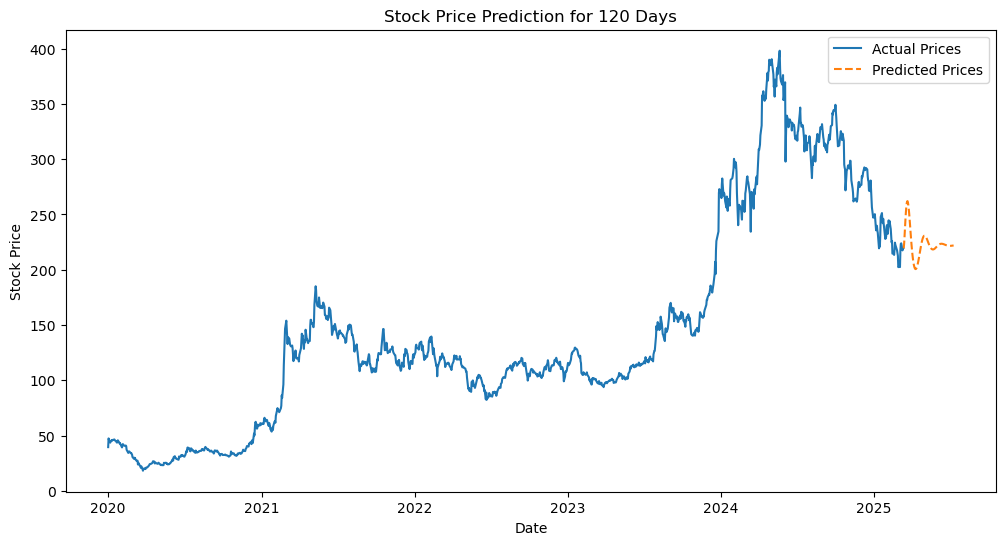

In [7]:
# Plot results
def plot_predictions(data, future_prices, future_days):
    plt.figure(figsize=(12, 6))

    # Plot actual stock prices
    plt.plot(data['Date'], data['Close'], label='Actual Prices')

    # Generate future dates starting from the last date in actual data
    future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=future_days+1)[1:]

    # Adjust predicted prices to start from the last actual price
    future_prices = future_prices + (float(data['Close'].iloc[-1].item()) - float(future_prices.flatten()[0]))

    # Plot predicted prices
    plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='dashed')

    # Formatting
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title(f'Stock Price Prediction for {future_days} Days')

    # Show plot
    plt.show()

plot_predictions(data, future_prices, future_days)

